In [425]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [426]:
# Import the data
url = "https://raw.githubusercontent.com/Nexosis/sampledata/master/csgo-small.csv"
all_ds = pd.read_csv(url)

# Drop the rows with null values
all_ds = all_ds.dropna()

# Shuffle the rows to make sure the data is not sorted. In this case the data had the 'VACBanned' column 
# sorted to have all the 1 first so we want to shuffle that
df = all_ds.sample(frac = 1).reset_index(drop = True)

#Take a look at the data
df.head()

,win_ratio,total_accuracy,kill_to_death_ratio,total_wins_per_hour,mvp_per_round,total_headshots_per_round,accuracy_ssg08,accuracy_awp,accuracy_deagle,accuracy_aug,...,accuracy_nova,accuracy_p250,accuracy_p90,accuracy_sawedoff,accuracy_sg556,accuracy_tec9,accuracy_ump45,accuracy_xm1014,total_games_owned,VACBanned
0,0.51,0.19,1.16,21.44,0.09,0.67,0.34,0.38,0.20,0.17,...,0.14,0.21,0.14,0.11,0.14,0.13,0.11,0.15,70,0
1,0.49,0.18,1.23,19.64,0.08,0.78,0.26,0.31,0.21,0.24,...,0.24,0.18,0.11,0.14,0.44,0.31,0.35,0.40,19,0
2,0.50,0.20,1.08,18.15,0.14,1.36,0.33,0.39,0.27,0.24,...,0.24,0.18,0.18,0.19,0.20,0.20,0.20,0.20,9,1
3,0.49,0.17,1.03,23.26,0.10,0.34,0.30,0.38,0.27,0.17,...,0.16,0.15,0.13,0.16,0.14,0.14,0.17,0.17,37,1
4,0.50,0.13,1.21,22.39,0.11,0.46,0.20,0.23,0.18,0.16,...,0.14,0.16,0.13,0.12,0.13,0.11,0.14,0.16,273,0


In [427]:
# Explore the maximums and means of the features to see if those who are banned have much higher scores
print("\n--------------------MAXIMUMS-----------------------\n")
print(df.groupby('VACBanned').max().transpose())
print("\n--------------------MEANS-----------------------\n")
print(df.groupby('VACBanned').mean().transpose())
# In this case we see that some columns have values between 0-1 and others go all the way to 186 so we know that 
# later we will have to normalize the data in order to get them on an even scale 


--------------------MAXIMUMS-----------------------

VACBanned                       0       1
win_ratio                    0.78    0.89
total_accuracy               0.26    0.43
kill_to_death_ratio          2.65    6.45
total_wins_per_hour         55.62  186.04
mvp_per_round                0.33    0.64
total_headshots_per_round    3.30   11.96
accuracy_ssg08               0.74    0.89
accuracy_awp                 0.62    0.80
accuracy_deagle              0.66    0.67
accuracy_aug                 0.72    0.75
accuracy_scar20              0.94    0.97
accuracy_m4a1                0.40    0.59
accuracy_ak47                0.33    0.73
accuracy_bizon               1.07    0.65
accuracy_elite               0.95    0.93
accuracy_famas               0.51    0.58
accuracy_fiveseven           0.49    1.00
accuracy_g3sg1               1.79    2.33
accuracy_galilar             0.79    0.73
accuracy_glock               0.45    1.00
accuracy_hkp2000             0.51    0.57
accuracy_m249         

<AxesSubplot:ylabel='VACBanned'>

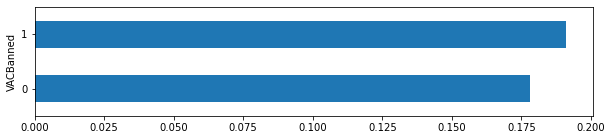

In [428]:
# Graph features by Banned (1) or not banned (0) to see the behaviour. See the difference in performance between the 
# banned players and those who arent banned

# Can uncomment to see different graphs
# df.groupby('VACBanned')['total_wins_per_hour'].mean().sort_values().plot(kind='barh',figsize=(10,2))
# df.groupby('VACBanned')['kill_to_death_ratio'].mean().sort_values().plot(kind='barh',figsize=(10,2))
df.groupby('VACBanned')['accuracy_glock'].mean().sort_values().plot(kind='barh',figsize=(10,2))

<AxesSubplot:title={'center':'accuracy_glock'}, xlabel='VACBanned'>

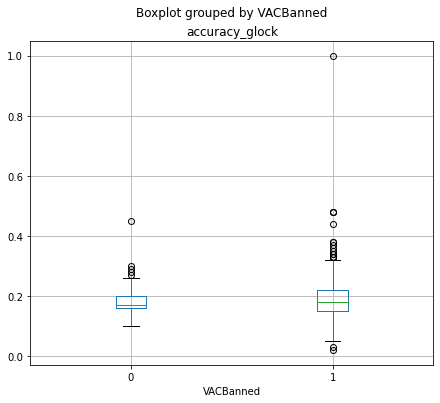

In [429]:
# Boxplots for different features grouped by banned or not banned
fig, ax = plt.subplots(figsize=(7,6))

# Uncomment to see different plots
# df.boxplot(column='total_wins_per_hour', by='VACBanned',ax=ax)
# df.boxplot(column='kill_to_death_ratio', by='VACBanned',ax=ax)
df.boxplot(column='accuracy_glock', by='VACBanned',ax=ax)

In [430]:
# Use Sklearn to split the data into the training and the test data
from sklearn.model_selection import train_test_split

# Split the data into X and Y variables 
X = df.loc[:, df.columns !='VACBanned'] #take all columns EXCEPT VACBanned Column
y = df.loc[:, df.columns =='VACBanned'] #take only the VACBanned column

# Split the data into 77% to train and the remaining 23% is to test
# We could use these straight away into the models but for more accurate results it's best to normalize the X data
X_train_pre_norm, X_test_pre_norm, y_train, y_test = train_test_split(X, y, test_size = 0.33) 

print(X_train_pre_norm.shape, X_test_pre_norm.shape, y_train.shape, y_test.shape)

(657, 36) (325, 36) (657, 1) (325, 1)


In [431]:
# Normalize the data
from sklearn import preprocessing

# Normalize the training data (X_train)
std_scale = preprocessing.StandardScaler().fit(X_train_pre_norm)
X_train_array = std_scale.transform(X_train_pre_norm) 

# Convert np array to pandas df
X_train = pd.DataFrame(X_train_array, index = X_train_pre_norm.index, columns = X_train_pre_norm.columns)
# print(X_train.head())

# Normalize test data (X_test)
X_test_array = std_scale.transform(X_test_pre_norm)
X_test = pd.DataFrame(X_test_array, index = X_test_pre_norm.index, columns = X_train_pre_norm.columns)
# print(X_test.head())

In [432]:
# Now we can get into the models
# Function for the basic model
def basic_model():
    #Create the model
    model = Sequential()
    # We can play with the number of nodes and layers which we will see in the other models  
    # The sigmoid layer takes the input and outputs values between 0 and 1
    model.add(Dense(1, activation = 'sigmoid'))
    # Compile the model
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [433]:
# Function for the medium model. This one has more layers and nodes than the previous
def medium_model():
    #Create the model
    model = Sequential()
    # We can play with the number of nodes and layers to try to improve our model
    # Relu is a piecewise linear function that will output the input directly if its positive, otherwise output is 0
    # When in doubt use Relu. It is the most commonly used and a good first choice
    # When using Relu activation, its not necessary but good practice to use a 'he_normal' or 
    #'he_uniform' weight initialization (kernel_initializer)
    model.add(Dense(12, input_shape = (X_train.shape[1],), activation = 'relu', kernel_initializer = 'he_normal'))
    model.add(Dense(8, activation = 'relu', kernel_initializer = 'he_normal'))
    
    # This last layer (sigmoid) takes the input (output from previous layer) and outputs values between 0 and 1
    model.add(Dense(1, activation = 'sigmoid'))  
    # Compile the model
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [434]:
# Function for the larger model with added layers. This one has even more layers and nodes than the previous
def large_model():
    #Create the model
    model = Sequential()
    # We can play with the number of nodes and layers to try to improve our model
    # Relu is a piecewise linear function that will output the input directly if its positive, otherwise output is 0
    # When in doubt use Relu. It is the most commonly used and a good first choice
    # When using Relu activation, its not necessary but good practice to use a 'he_normal' or 
    #'he_uniform' weight initialization (kernel_initializer)
    model.add(Dense(32, input_shape = (X_train.shape[1],), activation = 'relu', kernel_initializer = 'he_normal'))
    model.add(Dense(16, activation = 'relu', kernel_initializer = 'he_normal'))
    model.add(Dense(8, activation = 'relu', kernel_initializer = 'he_normal'))
    
    # This last layer (sigmoid) takes the input (output from previous layer) and outputs values between 0 and 1
    model.add(Dense(1, activation = 'sigmoid'))
    # Compile the model
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [435]:
#Decide which model will be used for the fitting and observing. Uncomment the one you want
model_to_use = basic_model()
# model_to_use = large_model()
# model_to_use = medium_model()

In [436]:
# Fit the model 
# You can play around with the numbers here to see what works best, gives you the best acuracy,
# doesnt have overfitting and has good results in the confusion matrix. Ex: 
# Basic model Epochs = 10, batch_size = 10
# Medium model EP = 25, b_s = 85
# Large model EP=80, b_s = 12

history2 = model_to_use.fit(X_train, y_train, validation_data = (X_test, y_test),
                           epochs = 20, batch_size = 1, verbose = 0)
print(history2.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [437]:
# Evaluate the model and view its accuracy
loss, acc = model_to_use.evaluate(X_test, y_test, verbose = 0)
print('Accuracy of this model is: %.3f' % acc)

Accuracy of this model is: 0.711


In [438]:
# Make a prediction based on given input

# View the actual values (these ones are after normalization)
# print(X_test[25:26].transpose()) 
y_test_array = y_test.to_numpy()
actual_answer = y_test_array[25:26] # What is the actual answer for that row 

# What answer did the model predict for the selected row
yhat = model_to_use.predict(X_test[25:26]) 
print('For this row the model predicted: %.3f' %yhat)
print('The actual answer was: ', actual_answer)

# Say the model predicted 0.75 and the actual answer is 1, the model was correct
# If the model predicted 0.23 and the actual answer was 0, the model was correct
# If the model predicted 0.40 and the answer was 1, the model WAS NOT correct

For this row the model predicted: 0.140
The actual answer was:  [[0]]


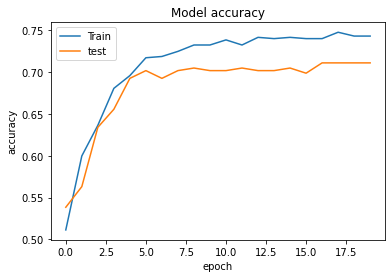

In [439]:
# plot the summary history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'test'], loc = 'upper left')
plt.show()
# If test set accuracy (orange) is much lower than the train accuracy (blue) it could mean that there is overfitting
# so decreasing number of epochs, batch size, number of layers in the model, number of neurons etc.

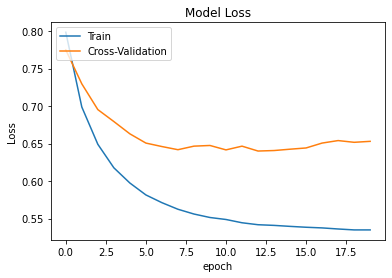

In [440]:
#plot history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'], loc = 'upper left')
plt.show()
# Decreasing loss (decreasing blue line) means the model is learning. If the blue doesnt go all the way to the bottom
# which means it is still learning so if we increase the number of epochs maybe it will keep learning more
# If the cross-validation starts going up it means we're overfitting so decrease epochs, change batch_size etc.

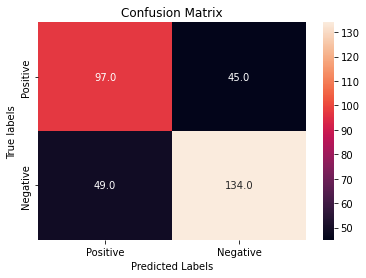

In [441]:
# Create a confusion matrix to see our results
from sklearn.metrics import confusion_matrix
import seaborn as sns

ax1 = plt.subplot()
predict_results = model_to_use.predict(X_test)
predict_results = (predict_results >= 0.5) # 0.5 is the threshold. Anything above 0.5 is 1, anything below is 0
cm = confusion_matrix(y_test, predict_results)

sns.heatmap(cm, annot = True, ax = ax1, fmt = ".1f"); #annot = True to annotate cells

ax1.set_xlabel('Predicted Labels');ax1.set_ylabel('True labels');
ax1.set_title('Confusion Matrix')
ax1.xaxis.set_ticklabels(['Positive', 'Negative']); ax1.yaxis.set_ticklabels(['Positive', 'Negative']);
# Looking at the confusion matrix, the top left corner and bottom right corner are the number of correct predictions
# the model made 
# The top right is False negatives so the model predicted 0 but the actual value was 1 
# The bottom left is False positives so the model predicted 1 but the actual value was 0